<a href="https://colab.research.google.com/github/akarshn95/Movie_Recommendation_System/blob/master/Movie_Recommender.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Movie Recommendation System

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
%cd /content/drive/My Drive/Kaggle

/content/drive/My Drive/Kaggle


In [3]:
# load data
df1 = pd.read_csv('tmdb_5000_credits.csv')
df2 = pd.read_csv('tmdb_5000_movies.csv')

In [4]:
# rename columns to maintain uniform labels
df1.columns = ['id','m_title','cast','crew']
df = df2.merge(df1,on='id')

In [5]:
df.head()

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,m_title,cast,crew
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466,Spectre,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106,The Dark Knight Rises,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de..."
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124,John Carter,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de..."


## Demographic Filtering

This is a very basic type of recommendation where we assume that the 'best' items will be widely liked by average users. This is not a custom recommendation but a general one. So, we just show the best movies as recommendations to all the users in the same demographic.

#### Weighted Rating - A IMDB rating that takes into consideration the number of votes for the final rating.

WR = v/(v+m) * R) + (m/(m+v) * C

- v is the number of votes for the movie;
- m is the minimum votes required to be listed in the chart;
- R is the average rating of the movie; And
- C is the mean vote across the whole report


In [6]:
C = np.mean(df.vote_average.values)
np.mean(df.vote_count.values)

# we find that the movies have an average of around 700 votes, let us keep the cutoff as 1000 votes
m = 1000

In [7]:
def calc_w_rating(x, C=C, m=m):
    v = x.vote_count
    R = x.vote_average
    return (v/(v+m) * R) + (m/(m+v) * C)

In [8]:
# qualifying movies with minimum 1000 votes
q_movies = df.copy().loc[df['vote_count']>999]
q_movies['w_rating'] = q_movies.apply(calc_w_rating, axis=1)

In [9]:
# sorted with top-rated movies at the top
q_movies = q_movies.sort_values('w_rating',ascending=False)
print("TOP 10 Movies by IMDB Rating")
q_movies[['original_title','w_rating','original_language','vote_average','vote_count']].head(10)

TOP 10 Movies by IMDB Rating


,original_title,w_rating,original_language,vote_average,vote_count
1881,The Shawshank Redemption,8.238422,en,8.5,8205
662,Fight Club,8.087974,en,8.3,9413
3232,Pulp Fiction,8.065822,en,8.3,8428
3337,The Godfather,8.065192,en,8.4,5893
65,The Dark Knight,8.037884,en,8.2,12002
96,Inception,7.963894,en,8.1,13752
809,Forrest Gump,7.963882,en,8.2,7927
95,Interstellar,7.930806,en,8.1,10867
1990,The Empire Strikes Back,7.893585,en,8.2,5879
1818,Schindler's List,7.885696,en,8.3,4329


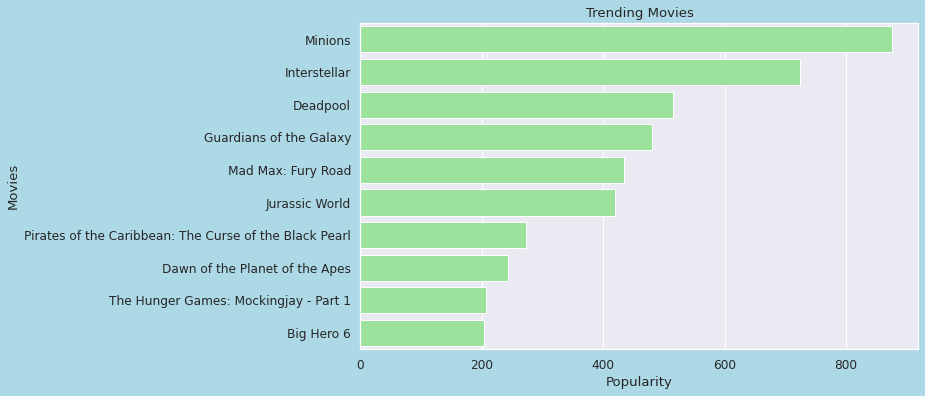

In [10]:
# to get the most trending movies, use the popularity score and arrange top popular movies

pop = df[['m_title','popularity']].sort_values('popularity', ascending=False).head(10)
plt.figure(figsize=(10,6),facecolor='lightblue')
sns.set(font_scale=1.1,style='darkgrid')
sns.barplot(y='m_title', x='popularity', data=pop, color='lightgreen')
plt.ylabel('Movies')
plt.xlabel('Popularity')
plt.title('Trending Movies')
plt.show()

## Content-based Filtering

In this type of filtering, we give pairwise similarity scores to movies and recommend movies that have a very high similarity to the movie that the user already watched. In our model, we will use a plot-based similarity recommender. We use the plot text data to base our movie similarities on.

In [11]:
df['overview'] = df['overview'].fillna('')

tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(df['overview'])

tfidf_matrix.shape

(4803, 20978)

In [12]:
# construct a reverse map of movie title and movie index
indices = pd.Series(df.index, index=df['m_title']).drop_duplicates()

In [13]:
# we use cosine similarity to calculate the similarity

# Compute the cosine similarity matrix
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

In [14]:
def get_recommendations(title, cosine_sim=cosine_sim):
    i = indices[title]

    # get similarity for the movie with respect to every other movie in the list
    similarity = list(enumerate(cosine_sim[i]))

    similarity = sorted(similarity, key=lambda x: x[1], reverse=True)
    # get top 10 movies
    similarity = similarity[1:11]
    idx = [x[0] for x in similarity]
    return df['m_title'].iloc[idx]

In [15]:
get_recommendations('The Godfather')

2731     The Godfather: Part II
1873                 Blood Ties
867     The Godfather: Part III
3727                 Easy Money
3623                       Made
3125                     Eulogy
3896                   Sinister
4506            The Maid's Room
3783                        Joe
2244      The Cold Light of Day
Name: m_title, dtype: object

In [16]:
get_recommendations('Deadpool')

873                                   Shaft
2375                       Midnight Special
3733                            Night Watch
473                           Mars Attacks!
30                             Spider-Man 2
4664                                Bronson
1110                  Underworld: Evolution
50      Prince of Persia: The Sands of Time
5                              Spider-Man 3
3742                                 Maggie
Name: m_title, dtype: object

We used movie descriptions for making recommendations, but they alone might not be able to fully provide us the best similarity score. Let us make use of genres, keywords and other features to make more revelant predictions. 

In [17]:
# Parse the stringified features into their corresponding python objects
from ast import literal_eval

features = ['cast', 'crew', 'keywords', 'genres','production_companies']
for feature in features:
    df[feature] = df[feature].apply(literal_eval)

In [18]:
# get name of director from crew list
def get_director(x):
    for i in x:
        if i['job']=='Director':
            return i['name']
    return np.NaN

In [19]:
# top 3 features for - cast, genres, keywords, production companies
def get_top_three(x):
    if isinstance(x, list):
        top = [i['name'] for i in x]
        # if there are more than 3 return top 3, else return all
        if len(top)>3:
            return top[:3]
        return top
    return []

In [20]:
# add director column
df['director'] = df['crew'].apply(get_director)

features = ['cast','genres','keywords','production_companies']
# get top 3 cast, generes, keywords
for feature in features:
    df[feature] = df[feature].apply(get_top_three)

In [21]:
df[['title','director','cast','keywords','genres','production_companies']].head(10)

,title,director,cast,keywords,genres,production_companies
0,Avatar,James Cameron,"[Sam Worthington, Zoe Saldana, Sigourney Weaver]","[culture clash, future, space war]","[Action, Adventure, Fantasy]","[Ingenious Film Partners, Twentieth Century Fo..."
1,Pirates of the Caribbean: At World's End,Gore Verbinski,"[Johnny Depp, Orlando Bloom, Keira Knightley]","[ocean, drug abuse, exotic island]","[Adventure, Fantasy, Action]","[Walt Disney Pictures, Jerry Bruckheimer Films..."
2,Spectre,Sam Mendes,"[Daniel Craig, Christoph Waltz, Léa Seydoux]","[spy, based on novel, secret agent]","[Action, Adventure, Crime]","[Columbia Pictures, Danjaq, B24]"
3,The Dark Knight Rises,Christopher Nolan,"[Christian Bale, Michael Caine, Gary Oldman]","[dc comics, crime fighter, terrorist]","[Action, Crime, Drama]","[Legendary Pictures, Warner Bros., DC Entertai..."
4,John Carter,Andrew Stanton,"[Taylor Kitsch, Lynn Collins, Samantha Morton]","[based on novel, mars, medallion]","[Action, Adventure, Science Fiction]",[Walt Disney Pictures]
5,Spider-Man 3,Sam Raimi,"[Tobey Maguire, Kirsten Dunst, James Franco]","[dual identity, amnesia, sandstorm]","[Fantasy, Action, Adventure]","[Columbia Pictures, Laura Ziskin Productions, ..."
6,Tangled,Byron Howard,"[Zachary Levi, Mandy Moore, Donna Murphy]","[hostage, magic, horse]","[Animation, Family]","[Walt Disney Pictures, Walt Disney Animation S..."
7,Avengers: Age of Ultron,Joss Whedon,"[Robert Downey Jr., Chris Hemsworth, Mark Ruff...","[marvel comic, sequel, superhero]","[Action, Adventure, Science Fiction]","[Marvel Studios, Prime Focus, Revolution Sun S..."
8,Harry Potter and the Half-Blood Prince,David Yates,"[Daniel Radcliffe, Rupert Grint, Emma Watson]","[witch, magic, broom]","[Adventure, Fantasy, Family]","[Warner Bros., Heyday Films]"
9,Batman v Superman: Dawn of Justice,Zack Snyder,"[Ben Affleck, Henry Cavill, Gal Gadot]","[dc comics, vigilante, superhero]","[Action, Adventure, Fantasy]","[DC Comics, Atlas Entertainment, Warner Bros.]"


In [22]:
# clean data by removing spaces and converting to lower case for the vectorizer

def clean_data(x):
    if isinstance(x, list):
        return [str.lower(i.replace(' ','')) for i in x]
    elif isinstance(x, str):
        return str.lower(x.replace(' ',''))
    else:
        return ''

In [23]:
# clean the new features
features = ['cast','genres','keywords','director','production_companies']

for feature in features:
    df[feature] = df[feature].apply(clean_data)

In [24]:
df[['title','director','cast','keywords','genres','production_companies']].head(6)

,title,director,cast,keywords,genres,production_companies
0,Avatar,jamescameron,"[samworthington, zoesaldana, sigourneyweaver]","[cultureclash, future, spacewar]","[action, adventure, fantasy]","[ingeniousfilmpartners, twentiethcenturyfoxfil..."
1,Pirates of the Caribbean: At World's End,goreverbinski,"[johnnydepp, orlandobloom, keiraknightley]","[ocean, drugabuse, exoticisland]","[adventure, fantasy, action]","[waltdisneypictures, jerrybruckheimerfilms, se..."
2,Spectre,sammendes,"[danielcraig, christophwaltz, léaseydoux]","[spy, basedonnovel, secretagent]","[action, adventure, crime]","[columbiapictures, danjaq, b24]"
3,The Dark Knight Rises,christophernolan,"[christianbale, michaelcaine, garyoldman]","[dccomics, crimefighter, terrorist]","[action, crime, drama]","[legendarypictures, warnerbros., dcentertainment]"
4,John Carter,andrewstanton,"[taylorkitsch, lynncollins, samanthamorton]","[basedonnovel, mars, medallion]","[action, adventure, sciencefiction]",[waltdisneypictures]
5,Spider-Man 3,samraimi,"[tobeymaguire, kirstendunst, jamesfranco]","[dualidentity, amnesia, sandstorm]","[fantasy, action, adventure]","[columbiapictures, lauraziskinproductions, mar..."


In [25]:
# create a soup of words for each movie which acts as its identity and 
# the similarity score with every other movie is calculated using this identity match with the other movies

def word_soup(x):
    return x['director'] + ' ' + ' '.join(x['genres']) + ' ' + ' '.join(x['keywords']) + ' ' + ' '.join(x['cast'])+ ' ' + ' '.join(x['production_companies'])

# create word soup
df['word_soup'] = df.apply(word_soup, axis=1)

In [26]:
df.word_soup[5]

'samraimi fantasy action adventure dualidentity amnesia sandstorm tobeymaguire kirstendunst jamesfranco columbiapictures lauraziskinproductions marvelenterprises'

In [27]:
count_vec = CountVectorizer(stop_words='english')
count_matrix = count_vec.fit_transform(df['word_soup'])

# this cosine similarity based on features produce much more closely matched similarities than the previous description match, which loosely matched movies
cosine_sim2 = cosine_similarity(count_matrix, count_matrix)

In [28]:
get_recommendations('The Godfather', cosine_sim2)

867     The Godfather: Part III
2731     The Godfather: Part II
1209              The Rainmaker
1170    The Talented Mr. Ripley
4209           The Conversation
2649          The Son of No One
4124         This Thing of Ours
1151            Double Jeopardy
1525             Apocalypse Now
1828           The Untouchables
Name: m_title, dtype: object

In [29]:
get_recommendations('The Avengers', cosine_sim2)

7                  Avengers: Age of Ultron
26              Captain America: Civil War
79                              Iron Man 2
169     Captain America: The First Avenger
85     Captain America: The Winter Soldier
174                    The Incredible Hulk
31                              Iron Man 3
68                                Iron Man
182                                Ant-Man
94                 Guardians of the Galaxy
Name: m_title, dtype: object

## Collaborative Filtering

In the above recommendation models, we used similarity of items alone to recommend to the user, but never really customized it to give subjective recommendations based on the preferences and biases of the user. All the above models give the same recommendation for every user. To take into consideration the liked and dislikes of the user in question for recommendation, we use Collaborative Filtering. There are two types :
- User-based Collaborative Filtering
- Item-based Collaborative Filtering

In [41]:
from surprise import Reader, SVD, Dataset
reader = Reader()
rating = pd.read_csv('ratings_small.csv')
rating.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [50]:
from surprise.model_selection import cross_validate, KFold

data = Dataset.load_from_df(rating[['userId', 'movieId', 'rating']], reader)
kf = KFold(n_splits=5)
kf.split(data)
svd = SVD()
cross_validate(svd, data, measures=['RMSE', 'MAE'])

{'fit_time': (5.153843402862549,
  5.127818584442139,
  5.22000527381897,
  5.103544473648071,
  5.227070569992065),
 'test_mae': array([0.68612684, 0.69088684, 0.6898814 , 0.694451  , 0.68456245]),
 'test_rmse': array([0.8920593 , 0.89756912, 0.89576762, 0.90176301, 0.89083361]),
 'test_time': (0.13805842399597168,
  0.13768649101257324,
  0.1369946002960205,
  0.13689661026000977,
  0.13690805435180664)}

In [51]:
trainset = data.build_full_trainset()
svd.fit(trainset)

In [53]:
rating[rating['userId'] == 1]

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205
5,1,1263,2.0,1260759151
6,1,1287,2.0,1260759187
7,1,1293,2.0,1260759148
8,1,1339,3.5,1260759125
9,1,1343,2.0,1260759131


In [56]:
svd.predict(1, 302, 3)

Prediction(uid=1, iid=302, r_ui=3, est=2.907881008216766, details={'was_impossible': False})